<a href="https://colab.research.google.com/github/sergeevgithub/deep_learning_2018-19/blob/master/second/16.1%20%5Bhw%5Dsemantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>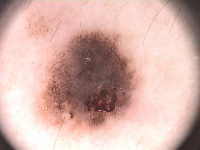</td><td>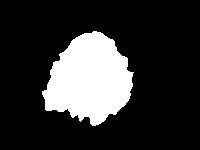</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [6]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-12-24 12:07:29--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-24 12:07:29--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf1211965ea3f96209dbfba99c2.dl.dropboxusercontent.com/cd/0/inline/BFqfQO3hPqGtLmaj3yyHAtUiYMEX7JbOijE7zop948C6OT858Yga5M5ncwegSgdKauHMSCQmHeHTz_e9CJyHcuu3bL-WC-cIzgv67L1P19p4tQ/file# [following]
--2020-12-24 12:07:29--  https://ucf1211965ea3f96209dbfba99c2.dl.dropboxusercontent.com/cd/0/inline/BFqfQO3hPqGtLmaj3yyHAtUiYMEX7JbOijE7zop948C6OT858Yga5M5ncwegSgdKauHMSCQmHeHTz_e9CJyHcuu3bL-WC-cIzgv67L1P19p4tQ/file
Resolving 

In [7]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [8]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [9]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [10]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [11]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

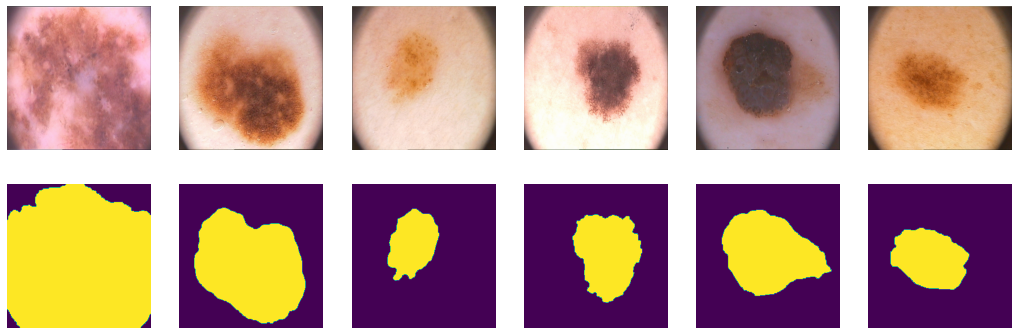

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [13]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [14]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [15]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

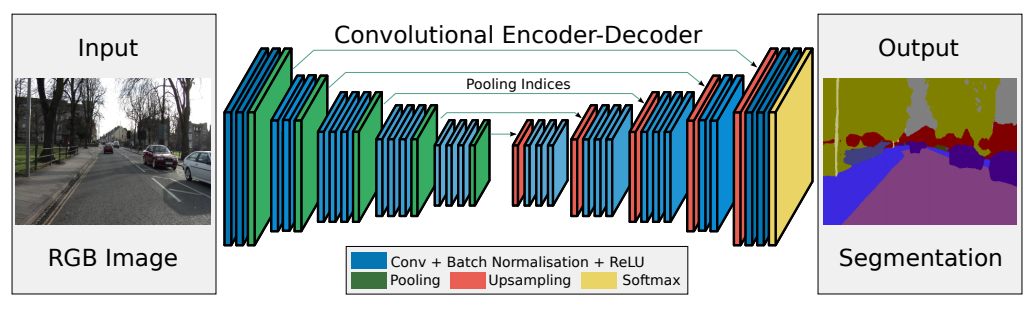

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time, localtime
from torchsummary import summary
torch.manual_seed(0)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [18]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            )
        self.bottleneck_pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(2, 2)
        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            )
        self.upsample2 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )
        self.upsample3 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, padding=1)
            )

    def forward(self, x):
        # encoder
        e0, indices0 = self.pool0(self.enc_conv0(x))
        e1, indices1 = self.pool1(self.enc_conv1(e0))
        e2, indices2 = self.pool2(self.enc_conv2(e1))
        e3, indices3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b1 = self.bottleneck_conv1(e3)
        b2, indices4 = self.bottleneck_pool(b1)
        b3 = self.bottleneck_unpool(b2, indices4)
        b4 = self.bottleneck_conv2(b3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b4, indices3))
        d1 = self.dec_conv1(self.upsample1(d0, indices2))
        d2 = self.dec_conv2(self.upsample2(d1, indices1))
        d3 = self.dec_conv3(self.upsample3(d2, indices0)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [19]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [20]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [21]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))
    losses_tr = []
    losses_val = []
    timeit = 0

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        timeit += (toc - tic)
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu
        loss_val = loss_fn(Y_val, Y_hat)
        losses_val.append(loss_val.item())
        losses_tr.append(avg_loss.item())

        # scheduler
        if scheduler:
            scheduler.step()
            print('lr: {}'.format(scheduler.get_lr()))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    # Visualize loss graph
    plt.plot(range(1, epochs+1), losses_tr, label='Train loss: {:.4f}'.format(min(losses_tr)))
    plt.plot(range(1, epochs+1), losses_val, label='Val loss: {:.4f}'.format(min(losses_val)))
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    timeit = localtime(timeit)
    print('Время обучения: {} min, {} sec'.format(timeit.tm_min, timeit.tm_sec))

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [22]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [23]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5 # <TODO>
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [24]:
def results(model):
    model_score_val = score_model(model, iou_pytorch, data_val)
    model_score_tr = score_model(model, iou_pytorch, data_tr)
    model_score_ts = score_model(model, iou_pytorch, data_ts)

    print('Результат на трейне: {:.4f}'.format(model_score_tr))
    print('Результат на валидации: {:.4f}'.format(model_score_val))
    print('Результат на тесте: {:.4f}'.format(model_score_ts))

    return model_score_val, model_score_ts

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
scores = {} # здесь будем хранить результаты для отчета

In [ ]:
model = SegNet().to(device)
print('Количество параметров: {}'.format(sum(p.numel() for p in model.parameters())))

Количество параметров: 29480641


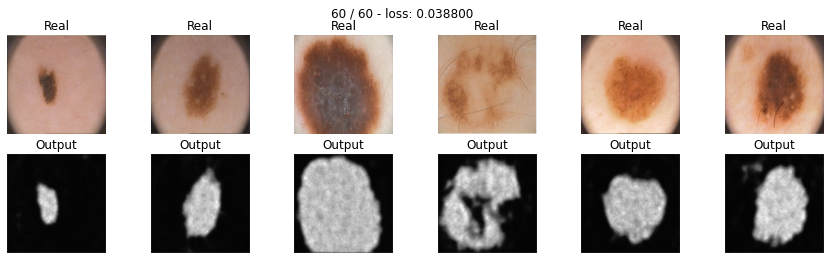

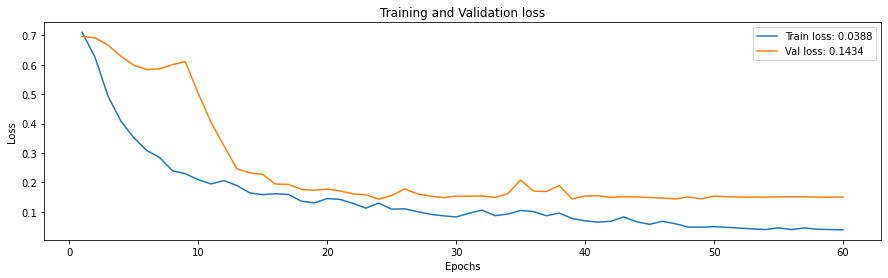

Время обучения: 4 min, 22 sec


In [ ]:
max_epochs = 60
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['segnet_bce'] = results(model)

Результат на трейне: 0.9980
Результат на валидации: 0.7420
Результат на тесте: 0.7520


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158)}

Ответьте себе на вопрос: не переобучается ли моя модель?

Модель переобучается, скор на трейне выше скоров на тесте и валидации.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = torch.sigmoid(y_pred)
    num = (2 * y_real * y_pred).sum(dim=(1, 2, 3))
    den =  (y_real + y_pred).sum(dim=(1, 2, 3))
    res = (num + SMOOTH) / (den + SMOOTH)
    return torch.mean(1 - res)

Проводим тестирование:

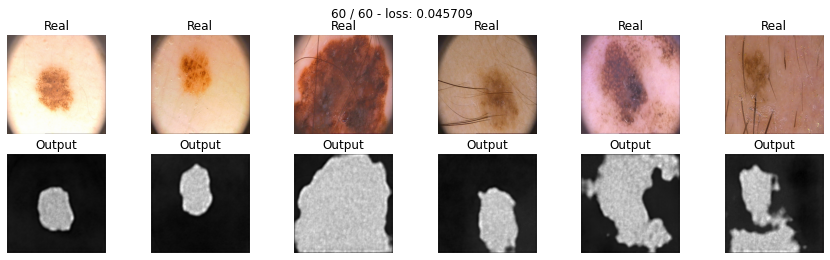

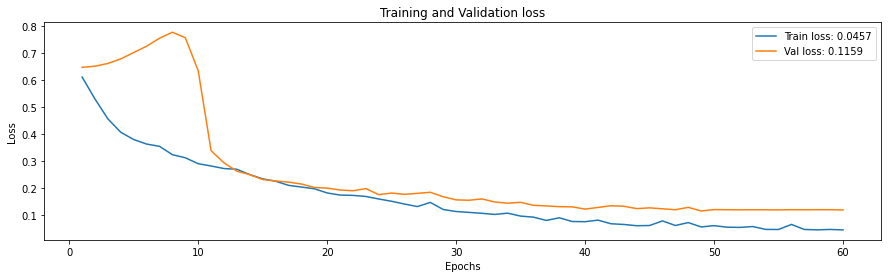

Время обучения: 4 min, 23 sec


In [ ]:
torch.cuda.empty_cache()
model_dice = SegNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['segnet_dice'] = results(model_dice)

Результат на трейне: 0.9990
Результат на валидации: 0.7460
Результат на тесте: 0.7740


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454)}

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps) # hint: torch.clamp
    res = ((1 - y_pred)**gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)).sum(dim=(1, 2, 3)) / (256 * 256)
    return torch.mean(-res)


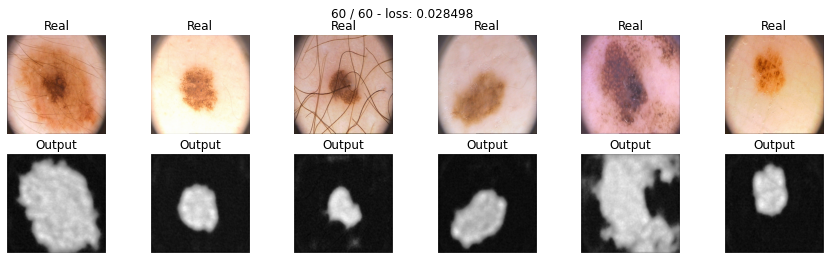

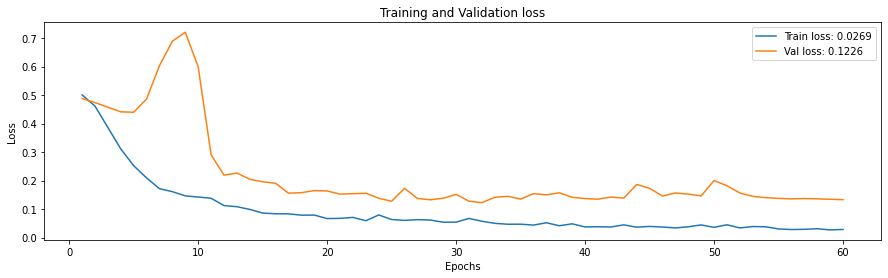

Время обучения: 4 min, 24 sec


In [ ]:
torch.cuda.empty_cache()
model_focal = SegNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(model_focal, optim, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['segnet_focal'] = results(model_focal)

Результат на трейне: 0.9660
Результат на валидации: 0.7540
Результат на тесте: 0.7700


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137)}

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# Реализуем ssl_loss (4-я ссылка)
def ssl_loss(y_real, y_pred, eps=0.01, beta=0.1):
    SMOOTH = 1e-8
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=SMOOTH)

    # Сначала вычисляем total error e, которая показывает уровень корреляции между пикселями (чем меньше, тем выше корреляция)
    def get_total_error(labels, preds):
      preds_normalized = (preds - preds.mean(dim=(2, 3), keepdim=True) + eps) / (preds.std(dim=(2, 3), keepdim=True) + eps)
      labels_normalized = (labels - labels.mean(dim=(2, 3), keepdim=True) + eps) / (labels.std(dim=(2, 3), keepdim=True) + eps)
      total_error = torch.abs(labels_normalized - preds_normalized)
      return total_error

    total_error = get_total_error(y_real, y_pred)

    # Теперь найдем сложные пиксели, те в которых total_error > beta * total_error_max,
    # где total_error_max - теоретически возможный максимум.
    """ Надо признать, что я не знаю точно, как находить total_error_max, поэтому пришлось действовать экспериментально:
    1) Если y_pred == y_real, то total_error во всех пикселях равняется 0;
    2) Если y_pred - это инвертированная y_real, то сумма total_error по картинке максимальна;
    3) Но сами total_error не обязательно одинаковы (видимо это как-то зависит от баланса классов и размера);
    4) Поэтому логично за total_error_max взять максимальную total_error, которая могла бы получиться, если бы
       y_pred была инвертированной y_real
       Вероятно, есть более строгие выводы total_error_max, но я их не нашел) буду багодарен за подсказки."""
    
    total_error_max = get_total_error(y_real, ((y_real == 1) == False).float()).max()
    # Вычислим маску (аналог f(n, c) в статье)
    mask = total_error > total_error_max * beta
    
    # Осталось собрать все вместе с BCE лоссом
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    ssl_loss = total_error * mask * bce
    return torch.mean(ssl_loss)

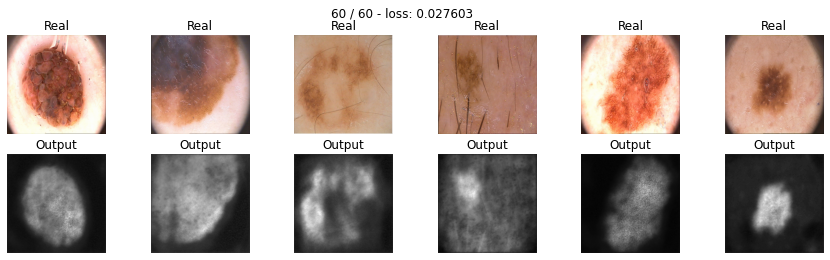

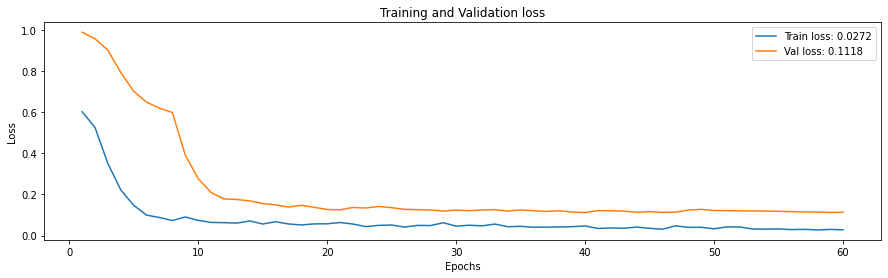

Время обучения: 4 min, 24 sec


In [ ]:
torch.cuda.empty_cache()
model_ssl = SegNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(model_ssl.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(model_ssl, optim, ssl_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['segnet_ssl'] = results(model_ssl)

Результат на трейне: 0.8450
Результат на валидации: 0.6420
Результат на тесте: 0.6700


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334)}

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

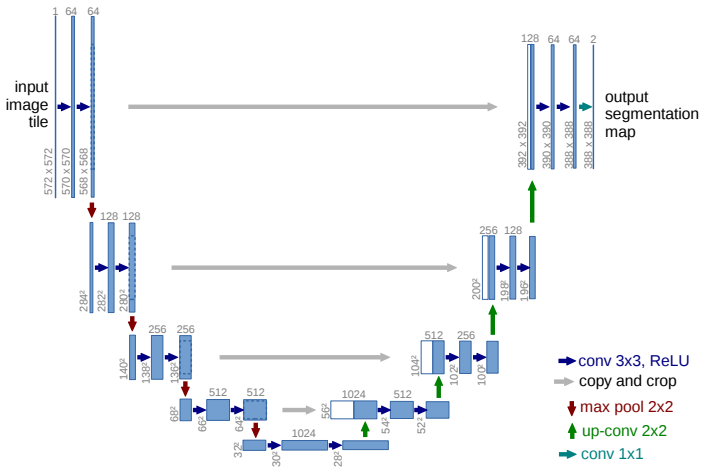

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def double_conv(in_c, out_c):
          conv = nn.Sequential(
              nn.Conv2d(in_c, out_c, 3, padding=1),
              nn.BatchNorm2d(out_c),
              nn.ReLU(inplace=True),
              nn.Conv2d(out_c, out_c, 3, padding=1),
              nn.BatchNorm2d(out_c),
              nn.ReLU(inplace=True)
          )
          return conv

        def upsample(in_c, out_c, out_size):
          up = nn.Sequential(
              nn.Upsample(out_size),
              nn.Conv2d(in_c, out_c, 3, padding=1)
          )
          return up

        # encoder (downsampling)
        self.enc_conv0 = double_conv(3, 64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = double_conv(64, 128)
        self.pool1 = nn.MaxPool2d(2, 2) # 128 -> 64
        self.enc_conv2 = double_conv(128, 256)
        self.pool2 = nn.MaxPool2d(2, 2) # 64 -> 32
        self.enc_conv3 = double_conv(256, 512)
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(512, 1024)

        # decoder (upsampling)
        self.upsample0 = upsample(1024, 512, 32) # 16 -> 32
        self.dec_conv0 = double_conv(1024, 512)
        self.upsample1 = upsample(512, 256, 64) # 32 -> 64
        self.dec_conv1 = double_conv(512, 256)
        self.upsample2 = upsample(256, 128, 128) # 64 -> 128
        self.dec_conv2 = double_conv(256, 128)
        self.upsample3 = upsample(128, 64, 256) # 128 -> 256
        self.dec_conv3 = double_conv(128, 64)
        self.out = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e1 = self.enc_conv0(x)   # конкатинируем
        e2 = self.pool0(e1)
        e3 = self.enc_conv1(e2)  # конкатинируем
        e4 = self.pool1(e3)
        e5 = self.enc_conv2(e4)  # конкатинируем
        e6 = self.pool2(e5)
        e7 = self.enc_conv3(e6)  # конкатинируем
        e8 = self.pool3(e7)

        # bottleneck
        b = self.bottleneck_conv(e8)

        # decoder
        d1 = self.upsample0(b)
        d2 = self.dec_conv0(torch.cat((e7, d1), dim=1))
        d3 = self.upsample1(d2)
        d4 = self.dec_conv1(torch.cat((e5, d3), dim=1))
        d5 = self.upsample2(d4)
        d6 = self.dec_conv2(torch.cat((e3, d5), dim=1))
        d7 = self.upsample3(d6)
        d8 = self.dec_conv3(torch.cat((e1, d7), dim=1))
        d9 = self.out(d8) # no activation
        return d9

In [ ]:
torch.cuda.empty_cache()
unet_bce = UNet().to(device)

print('Количество параметров: {}'.format(sum(p.numel() for p in unet_bce.parameters())))

Количество параметров: 34525633


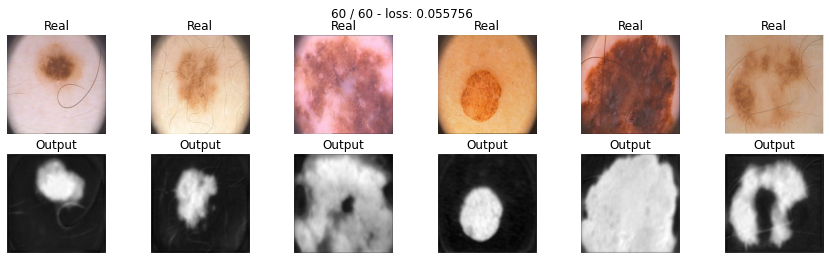

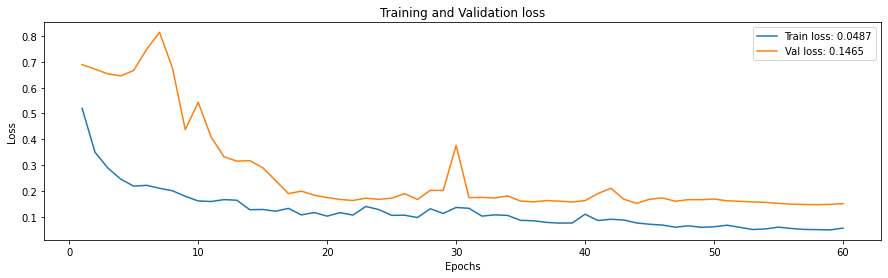

Время обучения: 5 min, 43 sec


In [ ]:
max_epochs = 60
optim = torch.optim.Adam(unet_bce.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet_bce, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet_bce'] = results(unet_bce)

Результат на трейне: 0.9380
Результат на валидации: 0.7600
Результат на тесте: 0.7820


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet_bce': (0.7599999904632568, 0.7819999754428864)}

## Unet с дополнительными лоссами

1) Dice_loss

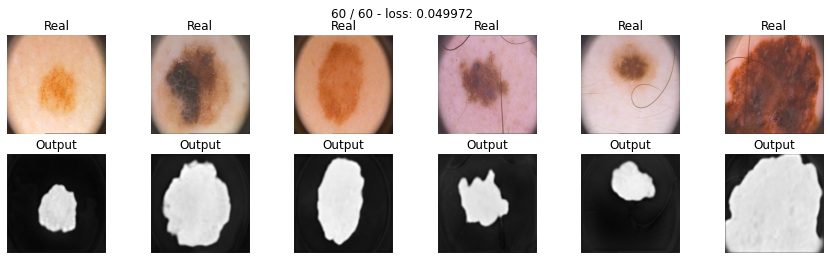

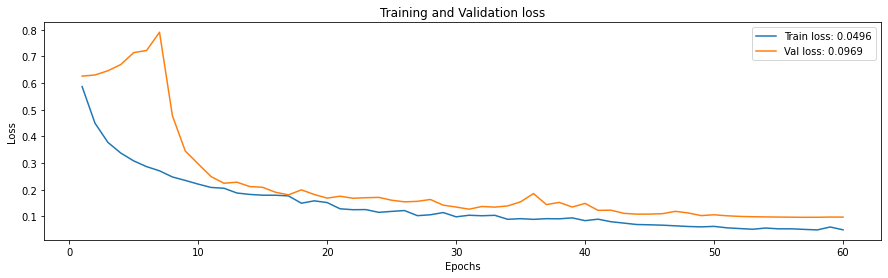

Время обучения: 5 min, 55 sec


In [ ]:
torch.cuda.empty_cache()
unet_dice = UNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet_dice, optim, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet_dice'] = results(unet_dice)

Результат на трейне: 0.9500
Результат на валидации: 0.7800
Результат на тесте: 0.8380


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628)}

2) Focal_loss

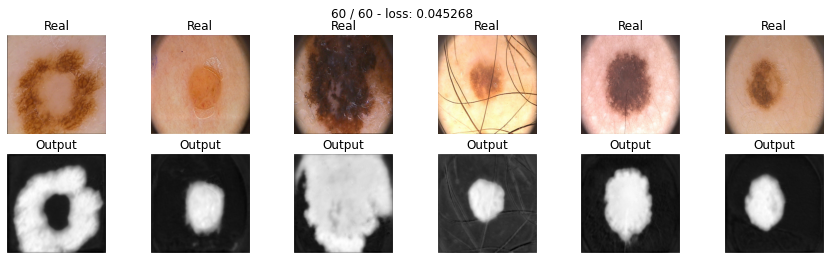

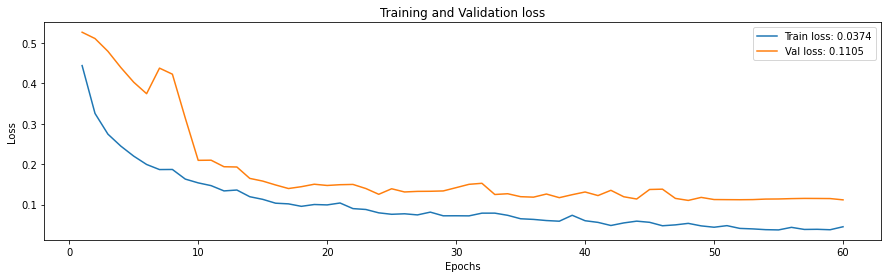

Время обучения: 6 min, 2 sec


In [ ]:
torch.cuda.empty_cache()
unet_focal = UNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet_focal, optim, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet_focal'] = results(unet_focal)

Результат на трейне: 0.9350
Результат на валидации: 0.7500
Результат на тесте: 0.7760


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388)}

3) SSL_loss

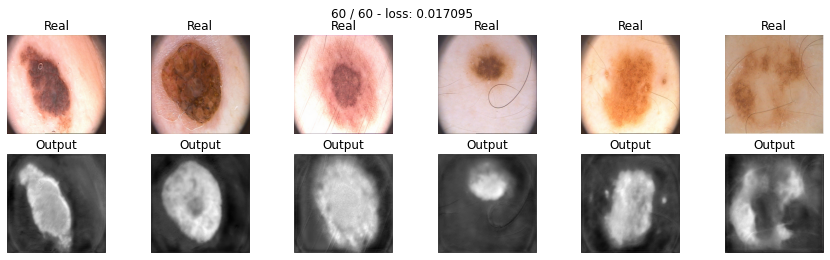

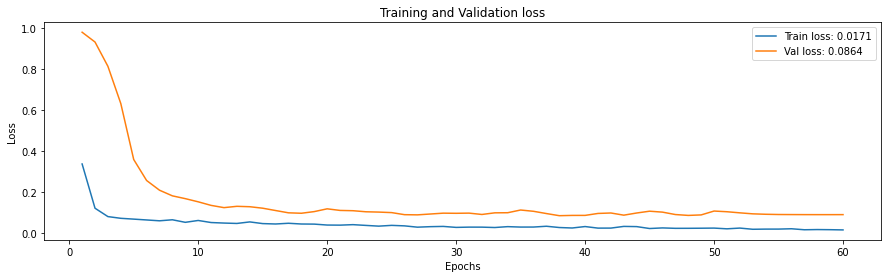

Время обучения: 6 min, 3 sec


In [ ]:
torch.cuda.empty_cache()
unet_ssl = UNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet_ssl.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet_ssl, optim, ssl_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet_ssl'] = results(unet_ssl)

Результат на трейне: 0.8990
Результат на валидации: 0.6580
Результат на тесте: 0.6920


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388),
 'unet_ssl': (0.6579999327659607, 0.69200000166893)}

## Unet2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        def double_conv(in_c, out_c):
          conv = nn.Sequential(
              nn.Conv2d(in_c, out_c, 3, padding=1),
              nn.BatchNorm2d(out_c),
              nn.ReLU(inplace=True),
              nn.Conv2d(out_c, out_c, 3, padding=1),
              nn.BatchNorm2d(out_c),
              nn.ReLU(inplace=True)
          )
          return conv

        def upsample(in_c, out_c):
          up = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
          return up

        # encoder (downsampling)
        self.enc_conv0 = double_conv(3, 64)
        self.pool0 = nn.Conv2d(64, 64, 3, stride=2, padding=1) # 256 -> 128
        self.enc_conv1 = double_conv(64, 128)
        self.pool1 = nn.Conv2d(128, 128, 3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = double_conv(128, 256)
        self.pool2 = nn.Conv2d(256, 256, 3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = double_conv(256, 512)
        self.pool3 = nn.Conv2d(512, 512, 3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(512, 1024)

        # decoder (upsampling)
        self.upsample0 = upsample(1024, 512) # 16 -> 32
        self.dec_conv0 = double_conv(1024, 512)
        self.upsample1 = upsample(512, 256) # 32 -> 64
        self.dec_conv1 = double_conv(512, 256)
        self.upsample2 = upsample(256, 128) # 64 -> 128
        self.dec_conv2 = double_conv(256, 128)
        self.upsample3 = upsample(128, 64) # 128 -> 256
        self.dec_conv3 = double_conv(128, 64)
        self.out = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e1 = self.enc_conv0(x)   # конкатинируем
        e2 = self.pool0(e1)
        e3 = self.enc_conv1(e2)  # конкатинируем
        e4 = self.pool1(e3)
        e5 = self.enc_conv2(e4)  # конкатинируем
        e6 = self.pool2(e5)
        e7 = self.enc_conv3(e6)  # конкатинируем
        e8 = self.pool3(e7)

        # bottleneck
        b = self.bottleneck_conv(e8)

        # decoder
        d1 = self.upsample0(b)
        d2 = self.dec_conv0(torch.cat((e7, d1), dim=1))
        d3 = self.upsample1(d2)
        d4 = self.dec_conv1(torch.cat((e5, d3), dim=1))
        d5 = self.upsample2(d4)
        d6 = self.dec_conv2(torch.cat((e3, d5), dim=1))
        d7 = self.upsample3(d6)
        d8 = self.dec_conv3(torch.cat((e1, d7), dim=1))
        d9 = self.out(d8) # no activation
        return d9


In [ ]:
torch.cuda.empty_cache()
unet2_bce = UNet2().to(device)

print('Количество параметров: {}'.format(sum(p.numel() for p in unet2_bce.parameters())))

Количество параметров: 34178433


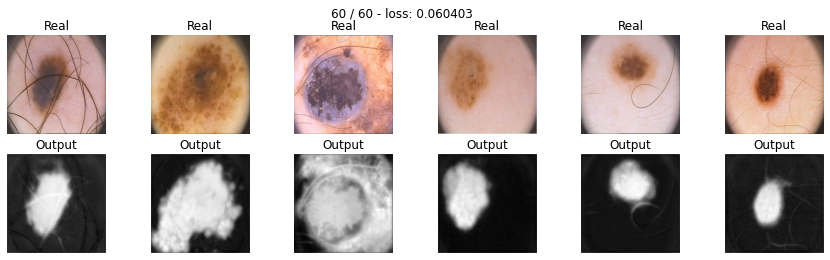

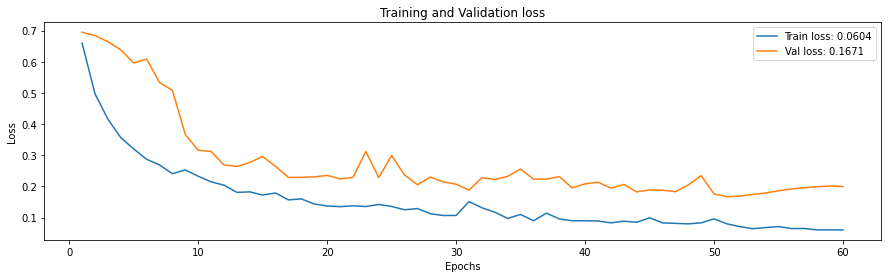

Время обучения: 6 min, 15 sec


In [ ]:
max_epochs = 60
optim = torch.optim.Adam(unet2_bce.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet2_bce, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet2_bce'] = results(unet2_bce)

Результат на трейне: 0.9220
Результат на валидации: 0.7440
Результат на тесте: 0.7920


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet2_bce': (0.7439999580383301, 0.7919999659061432),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388),
 'unet_ssl': (0.6579999923706055, 0.69200000166893)}

## Unet2 с дополнительными лоссами

1) Dice_loss

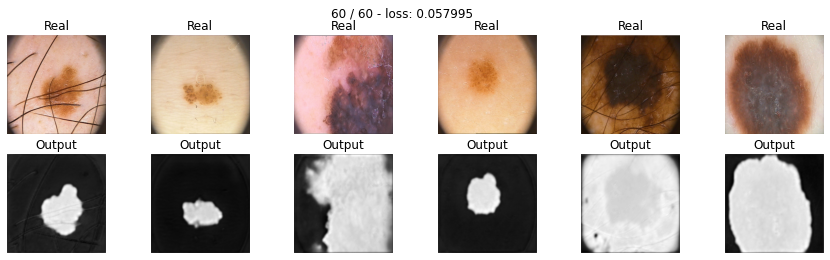

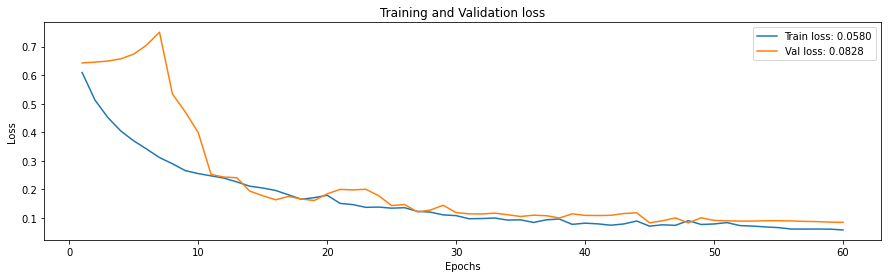

Время обучения: 5 min, 25 sec


In [ ]:
torch.cuda.empty_cache()
unet2_dice = UNet2().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet2_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet2_dice, optim, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet2_dice'] = results(unet2_dice)

Результат на трейне: 0.9180
Результат на валидации: 0.7960
Результат на тесте: 0.7940


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet2_bce': (0.7439999580383301, 0.7919999659061432),
 'unet2_dice': (0.7960000038146973, 0.7939999997615814),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388),
 'unet_ssl': (0.6579999923706055, 0.69200000166893)}

2) Focal_loss

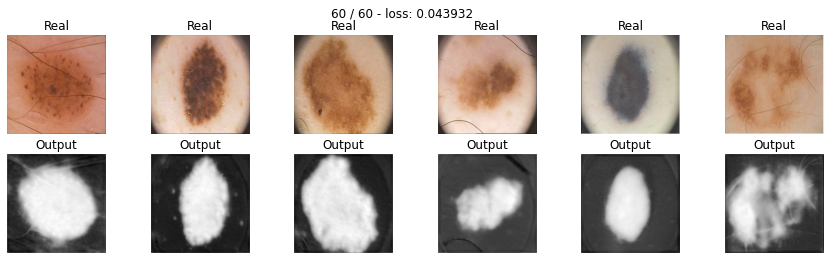

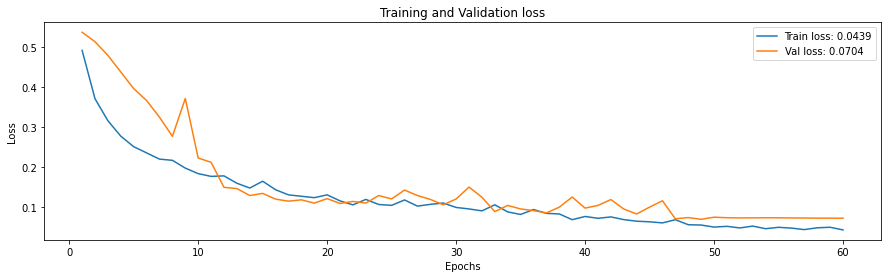

Время обучения: 5 min, 46 sec


In [ ]:
torch.cuda.empty_cache()
unet2_focal = UNet2().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet2_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet2_focal, optim, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet2_focal'] = results(unet2_focal)

Результат на трейне: 0.8970
Результат на валидации: 0.7760
Результат на тесте: 0.7640


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet2_bce': (0.7439999580383301, 0.7919999659061432),
 'unet2_dice': (0.7960000038146973, 0.7939999997615814),
 'unet2_focal': (0.776000052690506, 0.7639999985694885),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388),
 'unet_ssl': (0.6579999923706055, 0.69200000166893)}

3) SSL_loss

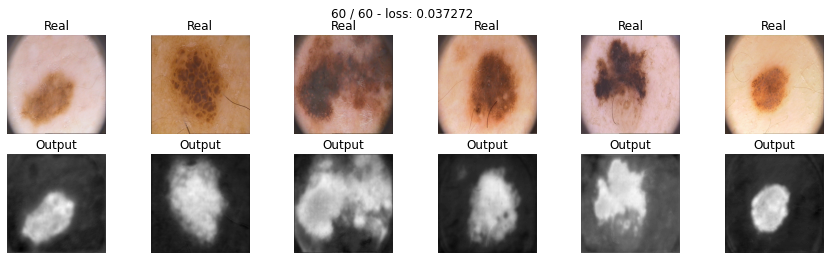

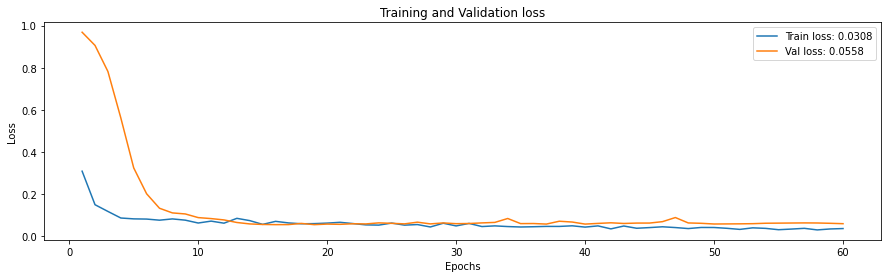

Время обучения: 5 min, 50 sec


In [ ]:
torch.cuda.empty_cache()
unet2_ssl = UNet2().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet2_ssl.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50, 60], gamma=0.1)
train(unet2_ssl, optim, ssl_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores['unet2_ssl'] = results(unet2_ssl)

Результат на трейне: 0.7490
Результат на валидации: 0.7120
Результат на тесте: 0.6360


In [ ]:
scores

{'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet2_bce': (0.7439999580383301, 0.7919999659061432),
 'unet2_dice': (0.7960000038146973, 0.7939999997615814),
 'unet2_focal': (0.776000052690506, 0.7639999985694885),
 'unet2_ssl': (0.7119999527931213, 0.636000007390976),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388),
 'unet_ssl': (0.6579999923706055, 0.69200000166893)}

In [1]:
scores = {'segnet_bce': (0.742000013589859, 0.7520000040531158),
 'segnet_dice': (0.7460000216960907, 0.7739999890327454),
 'segnet_focal': (0.7540000379085541, 0.7699999809265137),
 'segnet_ssl': (0.6419999897480011, 0.6699999272823334),
 'unet2_bce': (0.7439999580383301, 0.7919999659061432),
 'unet2_dice': (0.7960000038146973, 0.7939999997615814),
 'unet2_focal': (0.776000052690506, 0.7639999985694885),
 'unet2_ssl': (0.7119999527931213, 0.636000007390976),
 'unet_bce': (0.7599999904632568, 0.7819999754428864),
 'unet_dice': (0.7800000011920929, 0.8379999995231628),
 'unet_focal': (0.75, 0.7759999632835388),
 'unet_ssl': (0.6579999923706055, 0.69200000166893)}

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

### Сравнение моделей SegNet

In [96]:
def get_results(labels, title):
    """
    Показывает гистограммы результатов модели на валидационном и тестовом датасетах
    """    
    val_score = [scores[i][0] for i in labels]
    test_score = [scores[i][1] for i in labels]

    x = np.arange(len(labels))
    width = 0.3

    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    rects1 = ax.bar(x - width/2, val_score, width, label='val')
    rects2 = ax.bar(x + width/2, test_score, width, label='test')

    ax.set(ylim=[0.6, 0.85]) 
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

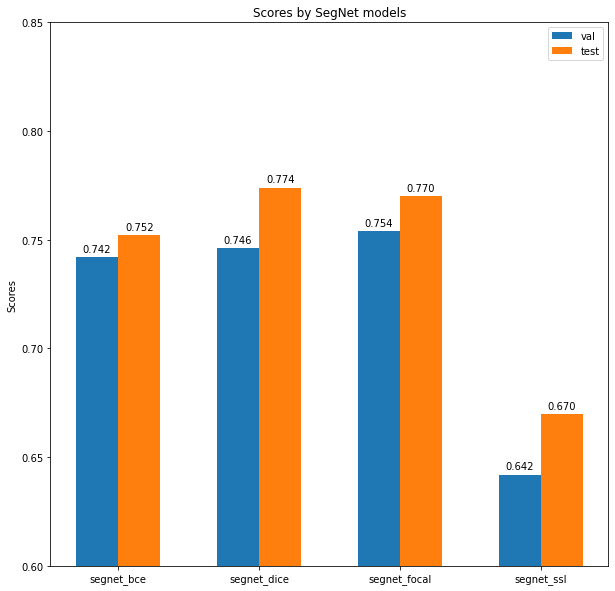

In [97]:
labels = ['segnet_bce', 'segnet_dice', 'segnet_focal', 'segnet_ssl']
get_results(labels, title='Scores by SegNet models')

На тестовом датасете лучший результат у segnet-dice, однако внимание заслуживает и segnet_focal, не сильно уступающая segnet_dice на тесте, а на валидации превосходящая его.

### Сравнение моделей U-Net

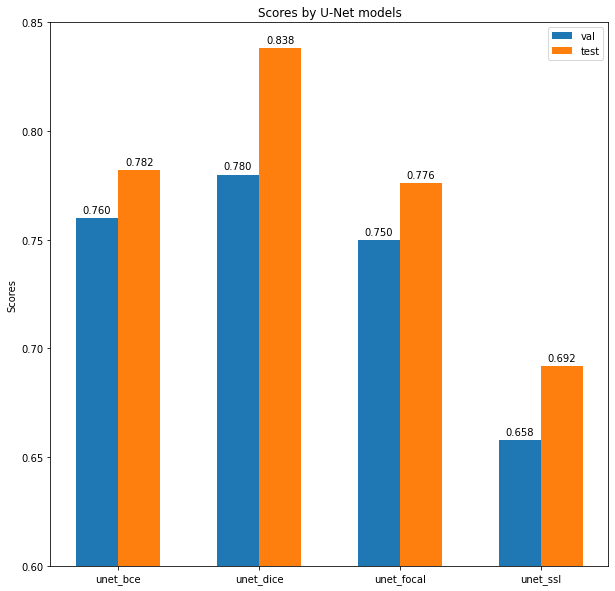

In [98]:
labels = ['unet_bce', 'unet_dice', 'unet_focal', 'unet_ssl']
get_results(labels, title='Scores by U-Net models')

Unet_dice показывает лучшие результаты как на тесте, так и на валидации

### Сравнение моделей модифицированной U-Net

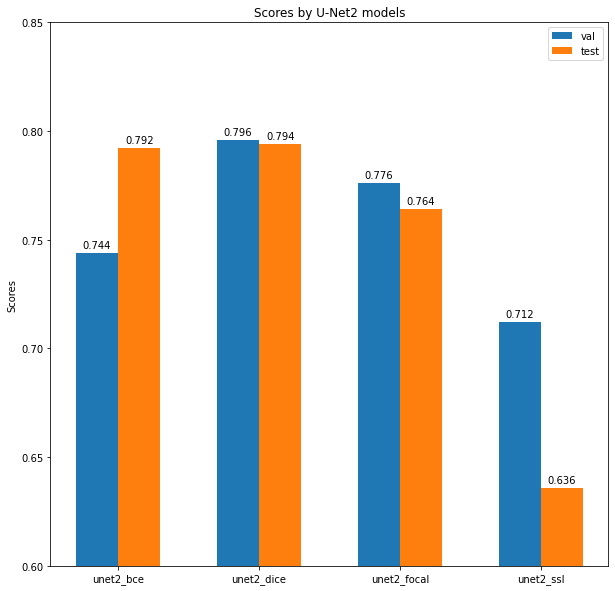

In [99]:
labels = ['unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_ssl']
get_results(labels, title='Scores by U-Net2 models')

Unet2_dice показывает лучшие результаты как на тесте, так и на валидации

### Сравнение лучших моделей

Таким образом лучшие результаты показывают модели, использующие dice_loss в качестве функции потерь. Сравним их между собой.

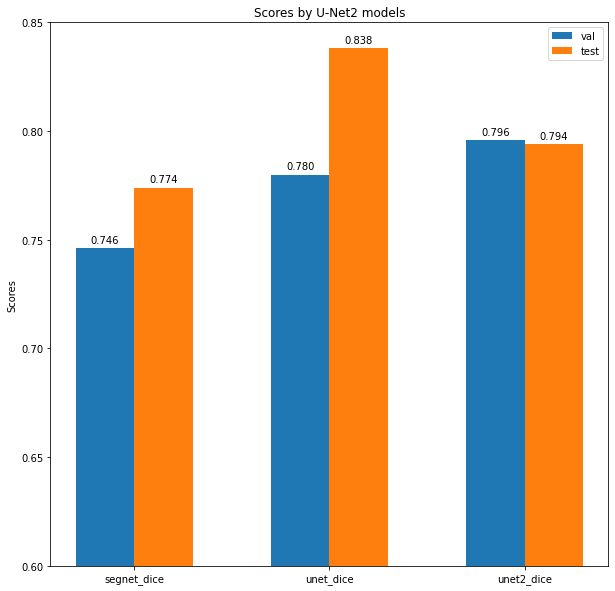

In [100]:
labels = ['segnet_dice', 'unet_dice', 'unet2_dice']
get_results(labels, title='Scores by U-Net2 models')

Лучшие результаты на тесте показывает unet_dice.

### Число параметров и время работы

Посмотрим на количество параметров в моделях

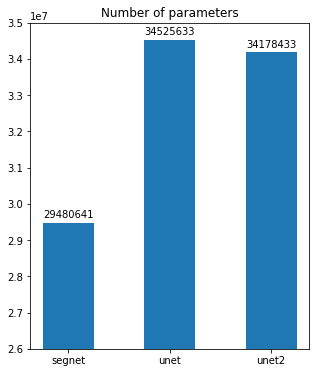

In [115]:
num_params = {'segnet': 29480641, 'unet': 34525633, 'unet2': 34178433}
labels = num_params.keys()
values = [num_params[i] for i in labels]

x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(5)
rects1 = ax.bar(x, values, width)

ax.set(ylim=[26e+6, 35e+6]) 
ax.set_title('Number of parameters')
ax.set_xticks(x)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

ax.set_xticklabels(labels)
plt.show()

Как видим, модели на базе U-Net имеют больше параметров.

Время обучения SegNet моделей практически одинаковое, в среднем 4 минуты 23 секунды

Время обучения U-Net моделей разнится сильнее, но тоже близкое, в среднем 5 минуты 56 секунд

Время обучения U-Net2 варьируется еще сильнее, в среднем 5 минуты 49 секунд

Видим, что число параметров модели влияет на время обучения.

# Итоги

Получилось довольно плотно поработать с функциями потерь. Поразбираться как они считаются в отдельных картинках и в батче в целом. К сожалению, нет полной уверенности в том, что все лоссы реализованы правильно (особенно ssl). 


Было сюрпризом, что unet модели не работают без батчнормализации, хотя в оригинальной статье про Batchnorm ничего не говорится.